In [3]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import mean_squared_error
import math


Load the image and ensure dimensions are divisible by 8.

In [ ]:
def load_and_preprocess_image(image_path):
    
    img = Image.open("C:/Users/snehi/Downloads/grayscale.png")

    width, height = img.size

    new_width = width - (width % 8)
    new_height = height - (height % 8)

    left = (width - new_width) // 2
    top = (height - new_height) // 2
    right = left + new_width
    bottom = top + new_height
    
    img = img.crop((left, top, right, bottom))
    return np.array(img)

Apply SVD to block and keep only top-k singular values.

In [ ]:
def compress_block(block, k):

    U, S, Vt = np.linalg.svd(block)
    U_k = U[:, :k]
    S_k = S[:k]
    Vt_k = Vt[:k, :]
    
    reconstructed = U_k @ np.diag(S_k) @ Vt_k
    return reconstructed

Apply block-wise SVD compression to the image.

In [ ]:
def block_wise_svd(image, block_size=8, k=1):
    
    height, width = image.shape
    compressed_blocks = []
    
    for i in range(0, height, block_size):
        row_blocks = []
        for j in range(0, width, block_size):
            block = image[i:i+block_size, j:j+block_size]
            compressed_block = compress_block(block, k)
            row_blocks.append(compressed_block)
        compressed_blocks.append(np.hstack(row_blocks))
    
    # Combine all blocks
    reconstructed_image = np.vstack(compressed_blocks)
    return reconstructed_image

Calculate compression ratio for a given k.

In [ ]:
def calculate_compression_ratio(k, block_size=8):

    original_size = block_size * block_size
    compressed_size = k * (block_size + block_size + 1)  # U: 8×k, Σ: k, Vᵀ: k×8
    return original_size / compressed_size


Calculate Peak Signal-to-Noise Ratio.

In [ ]:
def calculate_psnr(original, compressed):
    
    mse = mean_squared_error(original.flatten(), compressed.flatten())
    if mse == 0:
        return float('inf')
    max_pixel = 255.0
    psnr = 20 * math.log10(max_pixel / math.sqrt(mse))
    return psnr

Calculate Frobenius norm.

In [ ]:
def calculate_frobenius_norm(original, compressed):
    
    return np.linalg.norm(original - compressed)

k	Compression Ratio	Frobenius Norm	PSNR (dB)
1	3.7647		42225.23		36.29
2	1.8824		28160.26		41.83
3	1.2549		17645.24		46.35
4	0.9412		10804.94		49.42
5	0.7529		5726.75		50.88
6	0.6275		2218.03		51.20
7	0.5378		493.03		51.33
8	0.4706		214.29		51.53


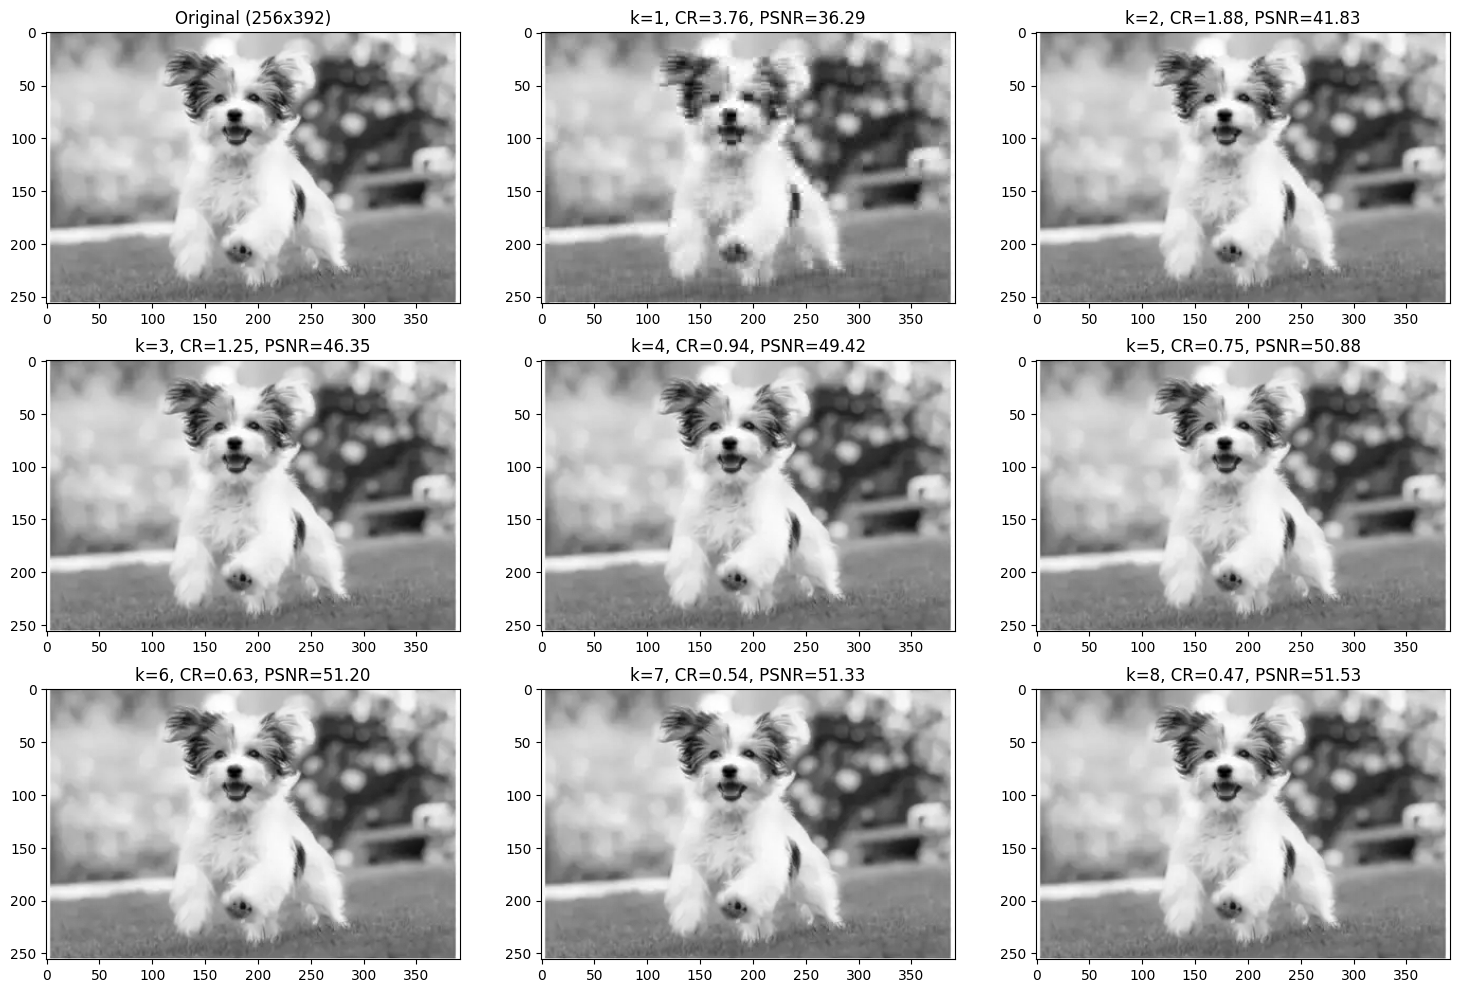

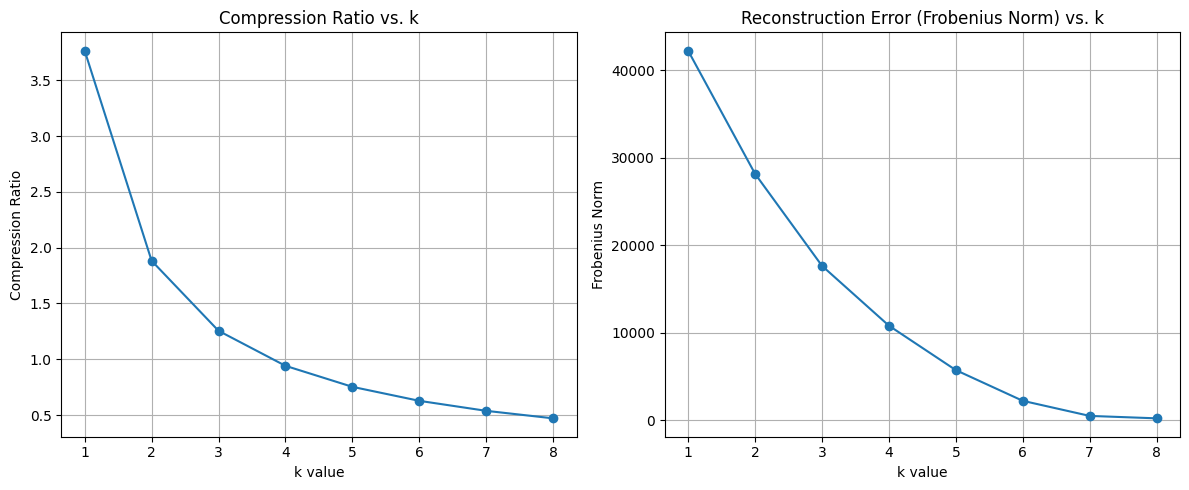

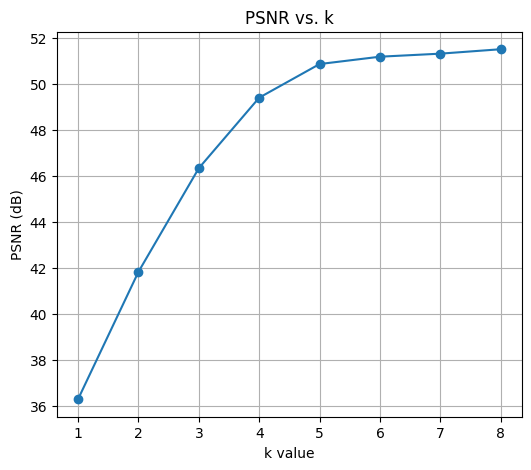

In [ ]:
def main(image_path):

    original_image = load_and_preprocess_image(image_path)
    
    k_values = range(1, 9)
    reconstructed_images = []
    compression_ratios = []
    frobenius_norms = []
    psnr_values = []
    
    plt.figure(figsize=(15, 10))
    plt.subplot(3, 3, 1)
    plt.imshow(original_image, cmap='gray')
    plt.title(f"Original ({original_image.shape[0]}x{original_image.shape[1]})")
    
    for idx, k in enumerate(k_values):
        reconstructed = block_wise_svd(original_image, k=k)
        reconstructed = np.clip(reconstructed, 0, 255).astype(np.uint8)
        reconstructed_images.append(reconstructed)
        
        compression_ratio = calculate_compression_ratio(k)
        compression_ratios.append(compression_ratio)
        
        frobenius_norm = calculate_frobenius_norm(original_image, reconstructed)
        frobenius_norms.append(frobenius_norm)
        
        psnr = calculate_psnr(original_image, reconstructed)
        psnr_values.append(psnr)
        
        # Plot reconstructed image
        plt.subplot(3, 3, idx + 2)
        plt.imshow(reconstructed, cmap='gray')
        plt.title(f"k={k}, CR={compression_ratio:.2f}, PSNR={psnr:.2f}")
    
    plt.tight_layout()
    plt.savefig('reconstructed_images.png')
    
    # Plot compression ratio vs. k
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(k_values, compression_ratios, marker='o')
    plt.title('Compression Ratio vs. k')
    plt.xlabel('k value')
    plt.ylabel('Compression Ratio')
    plt.grid(True)
    
    # Plot reconstruction error vs. k
    plt.subplot(1, 2, 2)
    plt.plot(k_values, frobenius_norms, marker='o')
    plt.title('Reconstruction Error (Frobenius Norm) vs. k')
    plt.xlabel('k value')
    plt.ylabel('Frobenius Norm')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('metrics.png')
    
    # Plot PSNR vs. k
    plt.figure(figsize=(6, 5))
    plt.plot(k_values, psnr_values, marker='o')
    plt.title('PSNR vs. k')
    plt.xlabel('k value')
    plt.ylabel('PSNR (dB)')
    plt.grid(True)
    plt.savefig('psnr.png')
    
    # Print metrics for each k
    print("k\tCompression Ratio\tFrobenius Norm\tPSNR (dB)")
    for k, cr, fn, psnr in zip(k_values, compression_ratios, frobenius_norms, psnr_values):
        print(f"{k}\t{cr:.4f}\t\t{fn:.2f}\t\t{psnr:.2f}")
    
    return reconstructed_images, compression_ratios, frobenius_norms, psnr_values

if __name__ == "__main__":

    image_path = "C:/Users/snehi/Downloads/grayscale.png"  
    main(image_path)